In [1]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam
from torch.utils.data import RandomSampler, SequentialSampler

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, models, to_hetero
from torch_geometric.loader import DataLoader, HGTLoader, NeighborLoader
from torch_geometric.loader import DenseDataLoader as DenseLoader
from tqdm import tqdm

from HeteroDataFunctions import Encoder, add_types, complete_graph, flatten_lol, node_cat_dict, midi_type, plot_graph, plot_4graphs

# print(scipy.__version__)
# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

2.0.0+cu118


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
# # Complete Dataset
# G = complete_graph(".\slac\embeddings\\all")
# nx.write_edgelist(G, ".\slac\homograph.edgelist", data=False)

In [4]:
G = nx.read_edgelist(".\slac\homograph.edgelist")

In [5]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [6]:
node_categories = node_cat_dict(nodes)
node_categories.keys()

node_cat_dict took 0.17 secs to run


dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [7]:
%%script false --no- raise -error

nodes_df_complete, edges_df_complete = add_types(nodes, edges, node_categories)

winsound.Beep(400, 700)

nodes_df_complete.to_csv('nodes_complete.csv')
edges_df_complete.to_csv('edges_complete.csv')

Couldn't find program: 'false'


In [8]:
nodes_df_complete = pd.read_csv('.\slac\Contents of Slac\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\slac\Contents of Slac\edges_complete.csv')
print('Done')

Done


In [9]:
node_types = set(nodes_df_complete['node_type'])
node_types


{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [10]:
edge_types = ["MIDI__has__tempo",
                   "MIDI__in__time_sig",
                   "MIDI__has__program",
                   "MIDI__has__note_group",
                   "note_group__has__velocity",
                   "note_group__has__duration",
                   "note_group__contains__pitch"]

In [11]:
names_list = flatten_lol(node_categories.values())


In [12]:
encoder = Encoder(names_list, n_labels=10)


In [13]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 0.00 secs to run
encode_nodes took 0.02 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 3.34 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.01 secs to run


In [14]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [15]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [16]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values
midi_class_5 = [midi_type(s[0], 5) for s in midi_val]

lb = LabelEncoder()
y_5 = torch.from_numpy(lb.fit_transform(midi_class_5)) # .type(torch.LongTensor)

lb.classes_

array(['Blues', 'Classical', 'Jazz', 'Rap', 'Rock'], dtype='<U9')

In [17]:
input_node_dict_5 = input_node_dict.copy()

input_node_dict_5['MIDI']['y'] = y_5

In [18]:
# H_5 = HeteroData(input_node_dict_5, **input_edge_dict).to(device)
# torch.save(H_5, '.\slac\H_5.pt')

In [19]:
H_5 = torch.load('.\slac\H_5.pt')

In [20]:
print(H_5)

HeteroData(
  program={ x=[108, 1] },
  tempo={ x=[23, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  pitch={ x=[93, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  time_sig={ x=[14, 1] },
  duration={ x=[570, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [21]:
H_5 = T.ToUndirected()(H_5)

In [22]:
#H_5 = T.RandomNodeSplit(num_val=0.1, num_test=0.1)(H_5)

In [23]:
print(H_5)

HeteroData(
  program={ x=[108, 1] },
  tempo={ x=[23, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  pitch={ x=[93, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  time_sig={ x=[14, 1] },
  duration={ x=[570, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 92484] },
  (pitch, rev_contains, note_group)={ edge_index=[2, 438

# GNN

In [24]:
model_5 = models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)))
model_5 = to_hetero(model_5, H_5.metadata(), aggr='sum')
model_5.to(device)
# model_5 = torch_geometric.compile(model_5)

GraphModule(
  (_trim): ModuleDict(
    (MIDI__has__tempo): TrimToLayer()
    (MIDI__in__time_sig): TrimToLayer()
    (MIDI__has__program): TrimToLayer()
    (MIDI__has__note_group): TrimToLayer()
    (note_group__has__velocity): TrimToLayer()
    (note_group__has__duration): TrimToLayer()
    (note_group__contains__pitch): TrimToLayer()
    (tempo__rev_has__MIDI): TrimToLayer()
    (time_sig__rev_in__MIDI): TrimToLayer()
    (program__rev_has__MIDI): TrimToLayer()
    (note_group__rev_has__MIDI): TrimToLayer()
    (velocity__rev_has__note_group): TrimToLayer()
    (duration__rev_has__note_group): TrimToLayer()
    (pitch__rev_contains__note_group): TrimToLayer()
  )
  (convs): ModuleList(
    (0): ModuleDict(
      (MIDI__has__tempo): SAGEConv(-1, 64, aggr=mean)
      (MIDI__in__time_sig): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__program): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__note_group): SAGEConv(-1, 64, aggr=mean)
      (note_group__has__velocity): SAGEConv(-1, 64, agg

In [25]:
def cross_validation_with_val_set(dataset, model, folds, epochs, batch_size,
                                  lr, lr_decay_factor, lr_decay_step_size,
                                  weight_decay, logger=None):

    val_losses, accs, durations = [], [], []
    for fold, (train_idx, test_idx,
               val_idx) in tqdm(enumerate(zip(*k_fold(dataset, folds)))):

        dataset['MIDI'].train_mask = train_idx
        dataset['MIDI'].val_mask = val_idx
        dataset['MIDI'].test_mask = test_idx

        train_dataset = dataset['MIDI'].x[dataset['MIDI'].train_mask]
        test_dataset = dataset['MIDI'].x[dataset['MIDI'].test_mask]
        val_dataset = dataset['MIDI'].x[dataset['MIDI'].val_mask]


        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_input_nodes = ('MIDI', train_dataset.to(torch.long))
        test_input_nodes = ('MIDI', test_dataset.to(torch.long))
        val_input_nodes = ('MIDI', val_dataset.to(torch.long))

        train_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
                                batch_size=batch_size, shuffle=True, input_nodes=train_input_nodes)
        val_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
                                batch_size=batch_size, shuffle=False, input_nodes=val_input_nodes)
        test_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
                                batch_size=batch_size, shuffle=False, input_nodes=test_input_nodes)

        model = model.to(device)
        reset_parameters(model)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = F.cross_entropy

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()


        for epoch in tqdm(range(1, epochs + 1)):
            train_loss = train(model, optimizer, loss_fn, train_loader)
            val_losses.append(eval_loss(model, loss_fn, val_loader))
            accs.append(eval_acc(model, test_loader))
            eval_info = {
                'fold': fold,
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_losses[-1],
                'test_acc': accs[-1],
            }

            if logger is not None:
                logger(eval_info)

            if epoch % lr_decay_step_size == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_decay_factor * param_group['lr']

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
        durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)
    loss, acc = loss.view(folds, epochs), acc.view(folds, epochs)
    loss, argmin = loss.min(dim=1)
    acc = acc[torch.arange(folds, dtype=torch.long), argmin]

    loss_mean = loss.mean().item()
    acc_mean = acc.mean().item()
    acc_std = acc.std().item()
    duration_mean = duration.mean().item()
    print(f'Val Loss: {loss_mean:.4f}, Test Accuracy: {acc_mean:.3f} '
          f'± {acc_std:.3f}, Duration: {duration_mean:.3f}')

    return loss_mean, acc_mean, acc_std


def k_fold(dataset, folds):
    skf = KFold(folds, shuffle=True, random_state=42)

    test_indices, train_indices = [], []
    for _, idx in skf.split(torch.zeros(len(dataset['MIDI'].x)), dataset['MIDI'].y):
        test_indices.append(torch.from_numpy(idx).to(torch.long))

    val_indices = [test_indices[i - 1] for i in range(folds)]


    for i in range(folds):
        train_mask = torch.ones(len(dataset['MIDI'].x), dtype=torch.bool)
        train_mask[test_indices[i]] = 0
        train_mask[val_indices[i]] = 0
        train_indices.append(train_mask.nonzero(as_tuple=False).view(-1))

    return train_indices, test_indices, val_indices

def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def num_graphs(data):
    if hasattr(data, 'num_graphs'):
        return data.num_graphs
    else:
        return data.x.size(0)


def train(model, optimizer, loss_fn, loader):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict)
        loss = loss_fn(out, data.y.view(-1))
        loss.backward()
        total_loss += loss.item() * num_graphs(data)
        optimizer.step()
    return total_loss / len(loader.dataset)


def eval_acc(model, loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data.x_dict, data.edge_index_dict)['MIDI'].argmax(dim=-1)
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


def eval_loss(model, loss_fn, loader):
    model.eval()

    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x_dict, data.edge_index_dict)
        loss += loss_fn(out, data.y.view(-1), reduction='sum').item()
    return loss / len(loader.dataset)


@torch.no_grad()
def inference_run(model, loader, bf16):
    model.eval()
    for data in loader:
        data = data.to(device)
        if bf16:
            data.x = data.x.to(torch.bfloat16)
        model(data)


In [ ]:
cross_validation_with_val_set(
    H_5,
    model=model_5,
    folds=10,
    epochs=1000,
    batch_size=32,
    lr=0.01,
    lr_decay_factor=0.5,
    lr_decay_step_size=50,
    weight_decay=0.0005,
    logger=None
)

0it [00:00, ?it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]

In [209]:
dataset = H_5
for fold, (train_idx, test_idx,
           val_idx) in enumerate(zip(*k_fold(dataset, 5))):

    dataset['MIDI'].train_mask = train_idx
    dataset['MIDI'].val_mask = val_idx
    dataset['MIDI'].test_mask = test_idx

    train_dataset = dataset['MIDI'].x[dataset['MIDI'].train_mask]
    test_dataset = dataset['MIDI'].x[dataset['MIDI'].test_mask]
    val_dataset = dataset['MIDI'].x[dataset['MIDI'].val_mask]


    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_input_nodes = ('MIDI', train_dataset)
    test_input_nodes = ('MIDI', test_dataset)
    val_input_nodes = ('MIDI', val_dataset)

print(train_input_nodes, test_input_nodes, val_input_nodes)

('MIDI', tensor([[92908.],
        [92859.],
        [92808.],
        [92723.],
        [92855.],
        [92925.],
        [92871.],
        [92876.],
        [92917.],
        [92794.],
        [92920.],
        [92906.],
        [92705.],
        [92928.],
        [92790.],
        [92801.],
        [92785.],
        [92764.],
        [92932.],
        [92852.],
        [92843.],
        [92814.],
        [92767.],
        [92885.],
        [92782.],
        [92777.],
        [92752.],
        [92817.],
        [92881.],
        [92916.],
        [92934.],
        [92844.],
        [92858.],
        [92740.],
        [92717.],
        [92780.],
        [92820.],
        [92890.],
        [92709.],
        [92870.],
        [92936.],
        [92706.],
        [92754.],
        [92895.],
        [92905.],
        [92886.],
        [92730.],
        [92891.],
        [92753.],
        [92835.],
        [92791.],
        [92853.],
        [92836.],
        [92745.],
        [92899.],
 

In [206]:
num_folds = 5
train_indices, test_indices, val_indices = k_fold(H_5, num_folds)

# Access the indices for each fold
for fold in range(num_folds):
    print(f"Fold {fold + 1}:")
    print("Train indices:", train_indices[fold])
    print("Test indices:", test_indices[fold])
    print("Validation indices:", val_indices[fold])
    print()

Fold 1:
Train indices: tensor([  0,   2,   3,   4,   5,   7,   8,  11,  12,  13,  17,  22,  23,  26,
         27,  28,  29,  31,  32,  34,  35,  36,  39,  40,  41,  42,  43,  44,
         46,  47,  49,  51,  53,  56,  59,  61,  62,  64,  65,  66,  70,  72,
         73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  89,
         90,  91,  93,  94,  95,  98, 100, 101, 105, 109, 110, 113, 115, 117,
        119, 122, 123, 124, 125, 126, 127, 128, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155,
        156, 158, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 175,
        178, 182, 183, 186, 190, 192, 193, 195, 198, 199, 204, 205, 206, 209,
        211, 212, 213, 215, 217, 218, 220, 223, 225, 226, 227, 228, 229, 231,
        232, 233, 234, 237, 238, 241, 243, 244, 245, 248])
Test indices: tensor([  6,   9,  10,  15,  16,  18,  19,  24,  25,  30,  33,  38,  45,  55,
         60,  67,  68,  69,  96,  97, 104, 108

[tensor([  0,   2,   3,   4,   5,   7,   8,  11,  12,  13,  17,  22,  23,  26,
          27,  28,  29,  31,  32,  34,  35,  36,  39,  40,  41,  42,  43,  44,
          46,  47,  49,  51,  53,  56,  59,  61,  62,  64,  65,  66,  70,  72,
          73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  89,
          90,  91,  93,  94,  95,  98, 100, 101, 105, 109, 110, 113, 115, 117,
         119, 122, 123, 124, 125, 126, 127, 128, 131, 132, 133, 134, 135, 136,
         137, 138, 139, 140, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155,
         156, 158, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 175,
         178, 182, 183, 186, 190, 192, 193, 195, 198, 199, 204, 205, 206, 209,
         211, 212, 213, 215, 217, 218, 220, 223, 225, 226, 227, 228, 229, 231,
         232, 233, 234, 237, 238, 241, 243, 244, 245, 248]),
 tensor([  0,   1,   2,   3,   4,   7,   8,  11,  13,  14,  17,  20,  21,  23,
          26,  27,  32,  34,  36,  37,  39,  40,  41,  43,  44,  46,  

In [64]:
optimizer_name = "Adam"
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)
# optimizer = getattr(torch.optim, optimizer_name)(model_5.parameters(), lr=lr)


In [65]:
def train5():
    model_5.train()
    optimizer.zero_grad()
    out = model_5(H_5.x_dict, H_5.edge_index_dict)
    mask = H_5['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_5['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [66]:
@torch.no_grad()
def test5():
    model_5.eval()
    pred = model_5(H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []

    for mask in [H_5['MIDI'].train_mask, H_5['MIDI'].val_mask, H_5['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_5['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [67]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []

for epoch in range(1, 401):
    loss = train5()
    train_acc, val_acc, test_acc = test5()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 51338.9688, Train: 0.3850, Val: 0.4000, Test: 0.3200
Epoch: 002, Loss: 148168.7031, Train: 0.2350, Val: 0.2000, Test: 0.2000
Epoch: 003, Loss: 182329.5781, Train: 0.2150, Val: 0.1200, Test: 0.2800
Epoch: 004, Loss: 207378.8125, Train: 0.2150, Val: 0.1200, Test: 0.2800
Epoch: 005, Loss: 163439.0781, Train: 0.3900, Val: 0.2800, Test: 0.4000
Epoch: 006, Loss: 74914.2500, Train: 0.4600, Val: 0.4800, Test: 0.5600
Epoch: 007, Loss: 23919.3809, Train: 0.3650, Val: 0.5200, Test: 0.3600
Epoch: 008, Loss: 37908.1094, Train: 0.2200, Val: 0.3200, Test: 0.2400
Epoch: 009, Loss: 54425.4492, Train: 0.2050, Val: 0.2400, Test: 0.2000
Epoch: 010, Loss: 85370.6875, Train: 0.4200, Val: 0.4400, Test: 0.3600
Epoch: 011, Loss: 70373.0547, Train: 0.3550, Val: 0.3200, Test: 0.3200
Epoch: 012, Loss: 75915.6875, Train: 0.2050, Val: 0.2000, Test: 0.1600
Epoch: 013, Loss: 84191.1797, Train: 0.2950, Val: 0.3600, Test: 0.2400
Epoch: 014, Loss: 66786.6719, Train: 0.3600, Val: 0.5200, Test: 0.3200
Ep

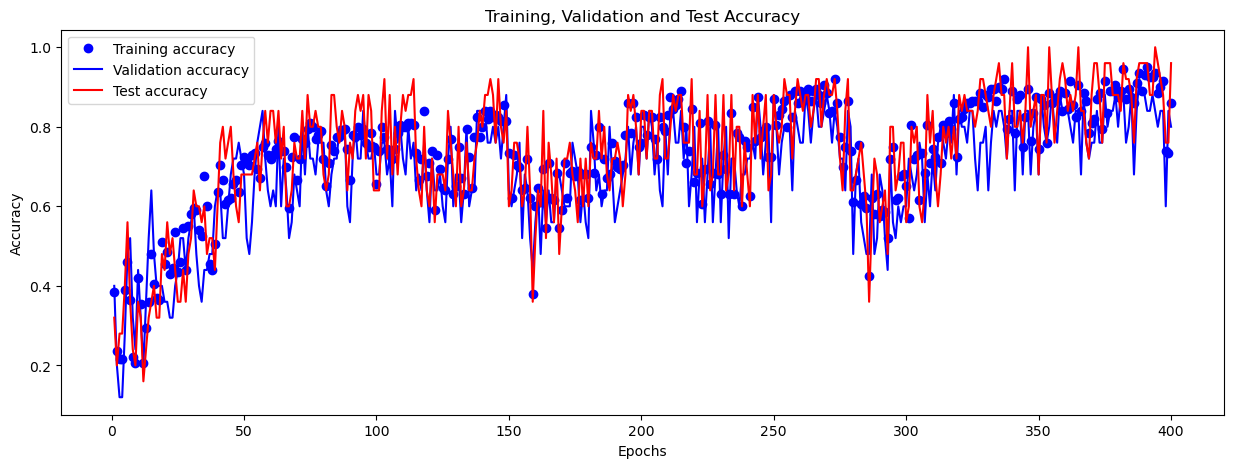

In [68]:
plot_graph(acc_lists)

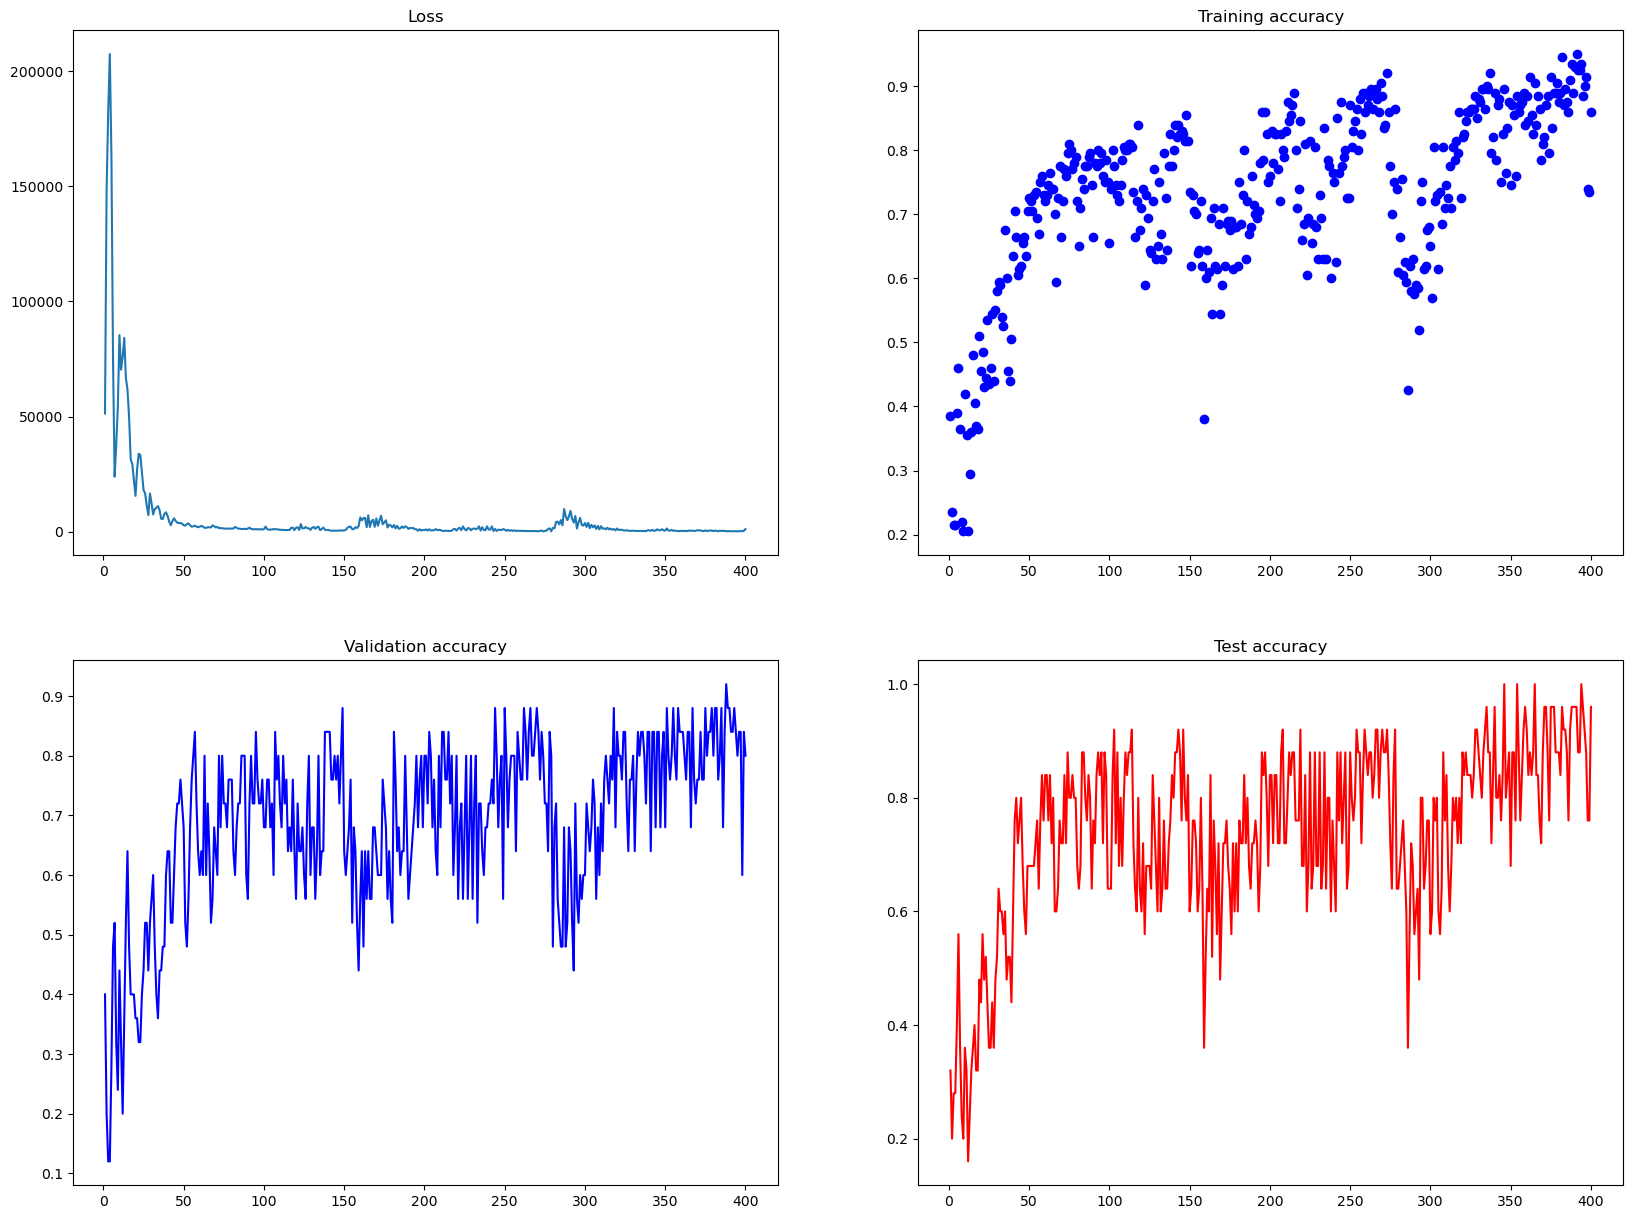

In [69]:
plot_4graphs(loss_list, acc_lists)

In [70]:
mask = H_5['MIDI'].test_mask

predicted = model_5(H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
        4], device='cuda:0')

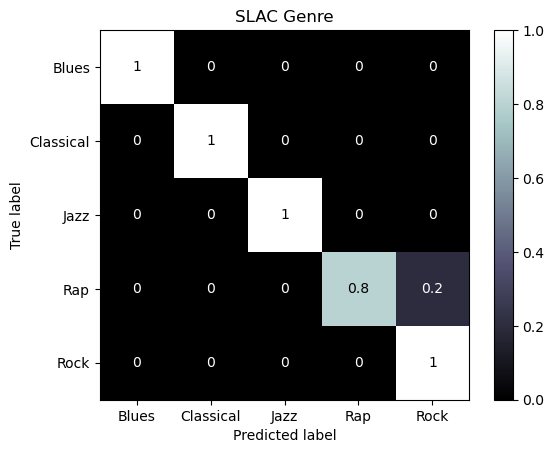

In [71]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H_5['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted.to('cpu')), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
plt.show()

## 10 class

In [72]:
nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']]

,name
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...
1029,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get
2248,Blues_-_Modern-B_B_King_-_Rock_Me_Baby
2686,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone
3738,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door
...,...
92865,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...
92925,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...
93030,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...
93133,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...


In [73]:
set([midi_type(s[0], 10) for s in midi_val])

{'Alternative',
 'Baroque',
 'Bop',
 'Hardcore_Rap',
 'Metal',
 'Modern',
 'Pop_Rap',
 'Romantic',
 'Swing',
 'Traditional'}

In [74]:
midi_class_10 = [midi_type(s[0], 10) for s in midi_val]

lb_10 = LabelEncoder()
y_10 = torch.from_numpy(lb_10.fit_transform(midi_class_10))  # .type(torch.LongTensor)

lb_10.classes_

array(['Alternative', 'Baroque', 'Bop', 'Hardcore_Rap', 'Metal', 'Modern',
       'Pop_Rap', 'Romantic', 'Swing', 'Traditional'], dtype='<U12')

In [75]:
input_node_dict_10 = input_node_dict.copy()

input_node_dict_10['MIDI']['y'] = y_10

In [76]:
H_10 = HeteroData(input_node_dict_10, **input_edge_dict).to(device)

In [77]:
print(H_10)

HeteroData(
  pitch={ x=[93, 1] },
  duration={ x=[570, 1] },
  note_group={ x=[92484, 1] },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  velocity={ x=[11, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [78]:
H_10 = T.ToUndirected()(H_10)

In [79]:
H_10 = T.RandomNodeSplit(num_val=0.1, num_test=0.1)(H_10)

In [80]:
print(H_10)

HeteroData(
  pitch={ x=[93, 1] },
  duration={ x=[570, 1] },
  note_group={ x=[92484, 1] },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  velocity={ x=[11, 1] },
  MIDI={
    x=[250, 1],
    y=[250],
    train_mask=[250],
    val_mask=[250],
    test_mask=[250]
  },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 924

In [81]:
model_10 = GCN(hidden_channels=64, out_channels=len(set(lb_10.classes_)), drop_layer=True)
model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')
model_10.to(device)

GraphModule(
  (conv1): ModuleDict(
    (MIDI__has__tempo): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__in__time_sig): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__has__program): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__has__velocity): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__has__duration): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__contains__pitch): SAGEConv((-1, -1), 64, aggr=mean)
    (tempo__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (time_sig__rev_in__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (program__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (velocity__rev_has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (duration__rev_has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (pitch__rev_contains__note_group): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (MIDI__has__tempo

In [82]:
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=0.01)

In [83]:
def train10():
    model_10.train()
    optimizer_10.zero_grad()
    out = model_10(H_10.x_dict, H_10.edge_index_dict)
    mask = H_10['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_10['MIDI'].y[mask])
    loss.backward()
    optimizer_10.step()
    return float(loss)

In [84]:
@torch.no_grad()
def test10():
    model_10.eval()
    pred = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []
    for mask in [H_10['MIDI'].train_mask, H_10['MIDI'].val_mask, H_10['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_10['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [85]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []
for epoch in range(1, 801):
    loss = train10()
    train_acc, val_acc, test_acc = test10()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 321662.5625, Train: 0.1250, Val: 0.0800, Test: 0.0800
Epoch: 002, Loss: 358153.1250, Train: 0.1500, Val: 0.1600, Test: 0.0400
Epoch: 003, Loss: 342014.0000, Train: 0.1150, Val: 0.1200, Test: 0.2000
Epoch: 004, Loss: 276464.8750, Train: 0.1000, Val: 0.2400, Test: 0.0400
Epoch: 005, Loss: 281832.8750, Train: 0.0750, Val: 0.2000, Test: 0.0800
Epoch: 006, Loss: 236875.9062, Train: 0.0950, Val: 0.2400, Test: 0.1600
Epoch: 007, Loss: 217711.7031, Train: 0.0750, Val: 0.2800, Test: 0.2400
Epoch: 008, Loss: 212563.9375, Train: 0.0950, Val: 0.1200, Test: 0.0800
Epoch: 009, Loss: 165928.5156, Train: 0.1350, Val: 0.0400, Test: 0.2000
Epoch: 010, Loss: 149308.3125, Train: 0.0500, Val: 0.0800, Test: 0.2400
Epoch: 011, Loss: 132843.3438, Train: 0.1300, Val: 0.0800, Test: 0.1200
Epoch: 012, Loss: 176128.2344, Train: 0.1950, Val: 0.0800, Test: 0.0400
Epoch: 013, Loss: 143326.3906, Train: 0.1550, Val: 0.1200, Test: 0.1600
Epoch: 014, Loss: 146115.5156, Train: 0.1900, Val: 0.2400, Test:

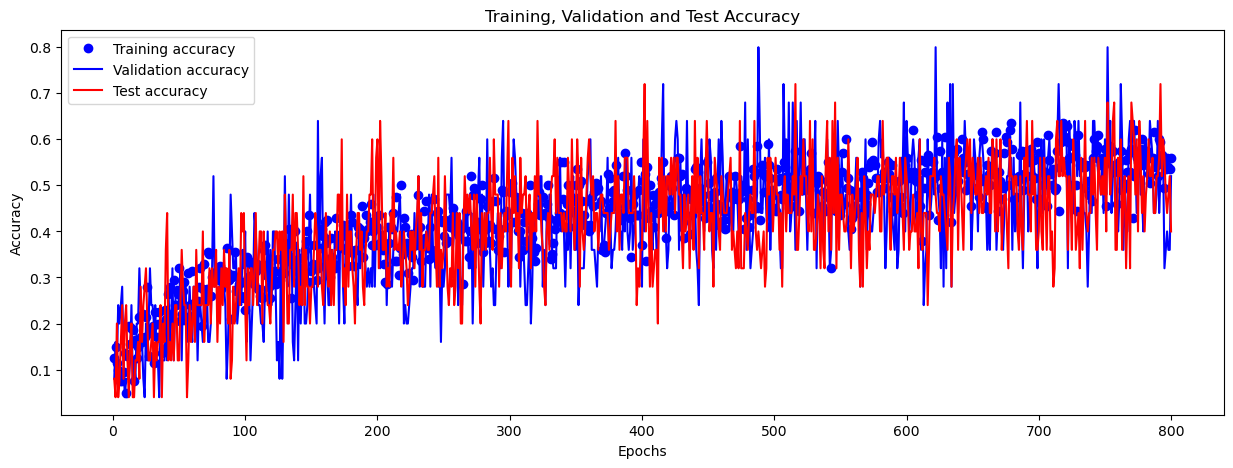

In [86]:
plot_graph(acc_lists)

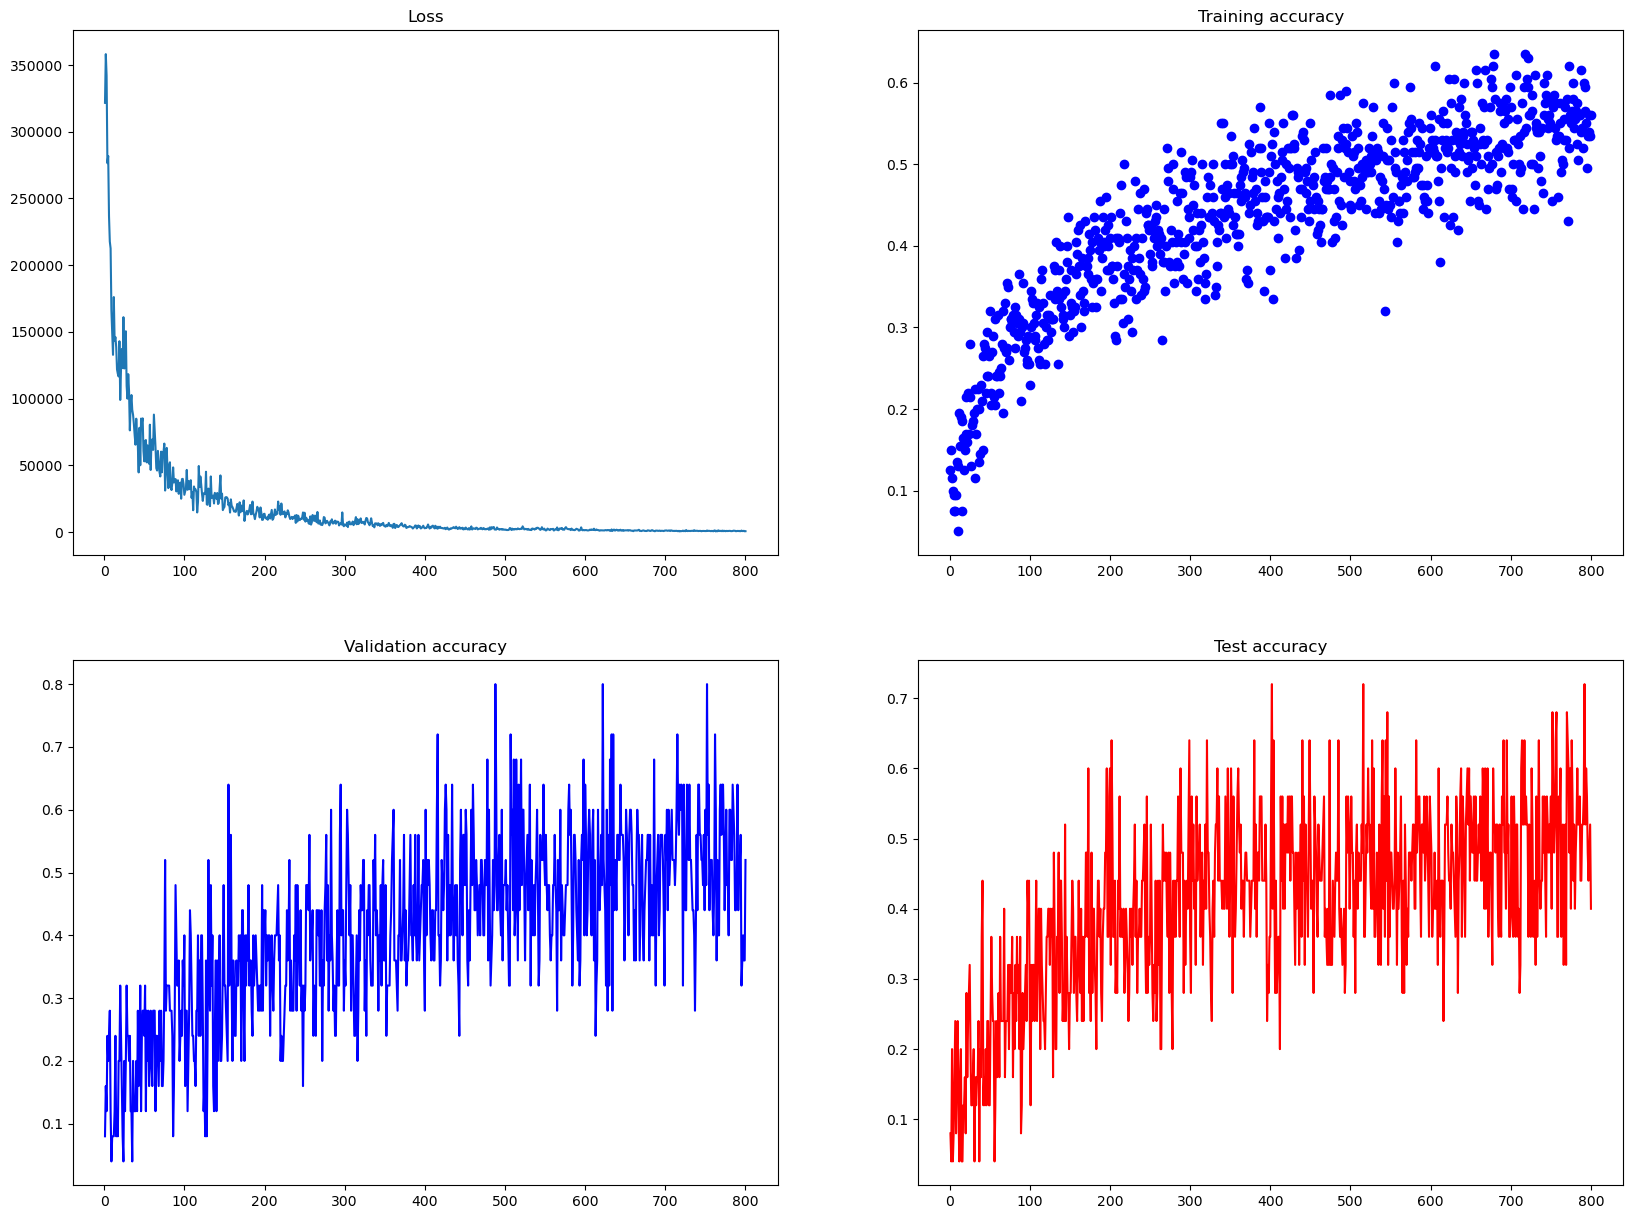

In [87]:
plot_4graphs(loss_list, acc_lists)

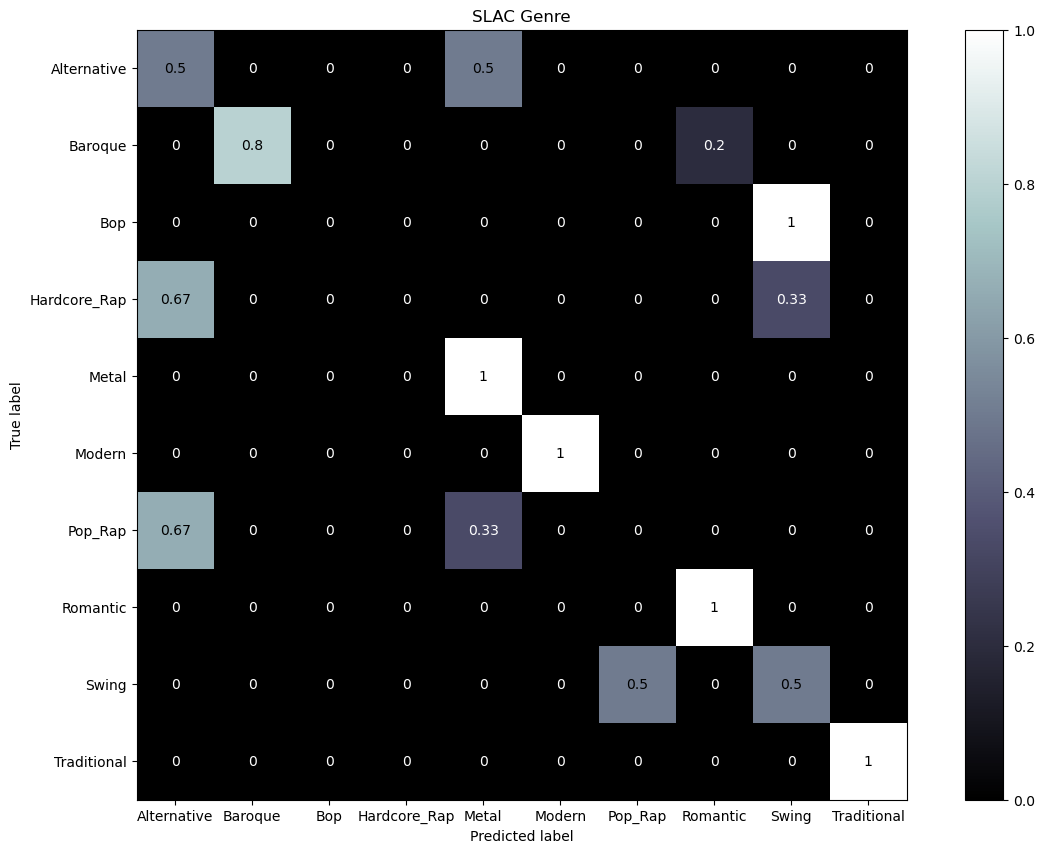

In [88]:
mask = H_10['MIDI'].test_mask

predicted = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb_10.inverse_transform(H_10['MIDI'].y[mask].to('cpu')),
                                               y_pred=lb_10.inverse_transform(predicted.to('cpu')), cmap='bone',
                                               normalize='true')

disp.ax_.set_title('SLAC Genre')
disp.figure_.set_size_inches(15, 10)
plt.show()

 # Old Implementation

In [ ]:
# #rewrite the function above without train_mask and test_mask
#  def train_epoch5(model, device, dataloader, loss_fn, optimizer):
#     train_loss, train_correct = 0.0, 0
#     model.train()
#     for batch in dataloader:
#         batch = batch.to(device)
#         optimizer.zero_grad()
#         out = model(batch.x_dict, batch.edge_index_dict)
#         loss = loss_fn(out['MIDI'], batch['MIDI'].y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * batch['MIDI'].num_nodes
#         scores, predictions = torch.max(out['MIDI'].data, 1)
#         train_correct += (predictions == batch['MIDI'].y).sum().item()
#     return train_loss, train_correct
#
#
# def valid_epoch5(model, device, dataloader, loss_fn):
#     valid_loss, val_correct = 0.0, 0
#     model.eval()
#     with torch.no_grad():
#         for batch in dataloader:
#             batch = batch.to(device)
#             output = model(batch.x_dict, batch.edge_index_dict)
#             loss = loss_fn(output['MIDI'], batch['MIDI'].y)
#             valid_loss += loss.item() * batch['MIDI'].num_nodes
#             scores, predictions = torch.max(output['MIDI'][mask].data, 1)
#             val_correct += (predictions == batch['MIDI'].y[mask]).sum().item()
#
#     return valid_loss, val_correct
#
#
# # define a training and testing function using kfold cross validation and torch.utils.data.DataLoader and prints the outputs for each iteration
# def train5(model, device, train_loader, test_loader, loss_fn, optimizer, epochs):
#     train_losses, train_corrects = [], []
#     val_losses, val_corrects = [], []
#     for epoch in range(epochs):
#         train_loss, train_correct = train_epoch5(model, device, train_loader, loss_fn, optimizer)
#         valid_loss, val_correct = valid_epoch5(model, device, test_loader, loss_fn)
#         train_losses.append(train_loss)
#         train_corrects.append(train_correct)
#         val_losses.append(valid_loss)
#         val_corrects.append(val_correct)
#         print(f'Epoch: {epoch + 1:02}')
#         print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_correct / len(train_loader.dataset):.4f}')
#         print(f'\t Val. Loss: {valid_loss:.4f} |  Val. Acc: {val_correct / len(test_loader.dataset):.4f}')
#     return train_losses, train_corrects, val_losses, val_corrects
#

# now write the code to run the above functions and define the parameters before the function call
# define the parameters
# loss_fn = F.cross_entropy
# optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)
# train_loader = DataLoader(H_5, batch_size=128, shuffle=True)
# test_loader = DataLoader(H_5, batch_size=128, shuffle=False)
#
# train5(model_5, device, train_loader, test_loader, loss_fn, optimizer, epochs=10)

In [89]:
# nodes_ten_ = encoder.encode_nodes(nodes_df_complete)
# edges_ten_ = encoder.encode_edges(edges_df_complete)

# node_type_ = nodes_df_complete.iloc[:, 1]

# Get the source and target indices from the edges tensor
# edge_index = edges_ten_[:, :2]

## Get the edge types from the edges tensor
#edge_type_ = edges_df_complete.iloc[:, 2]

#full_hetero_graph = HeteroData(x=nodes_ten_, node_type=node_type_, edge_index=edge_index, edge_type=edge_type_)

In [90]:
# edges_df_complete.loc[edges_df_complete['edge_type'] == 'MIDI__has__tempo', ['source', 'target']]

In [91]:
# full_categories = node_categories.copy()
# full_categories['node_types'] = list(node_categories.keys())
# full_categories['edge_types'] = edge_types  # Dictionary containing every string that may be found in our Dataframes
# names_list_full = flatten_lol(full_categories.values())

In [92]:
# input_edge_dict = {edge_type: {'edge_index': encoder.encode_edges(edges_df_complete.loc[
#                    edges_df_complete['edge_type'] == edge_type, ['source', 'target']])} for edge_type in edge_types}
# for key in input_edge_dict.keys():
#     input_edge_dict[key]['edge_index'] = input_edge_dict[key]['edge_index'].T.to(torch.int64)
